In [1]:
# Our Full Code

import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

# Dense Layer
class Layer_Dense:

    # Layer init
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

# ReLU activation function
class Activation_ReLU:

    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

# Softmax Activation Function
class Activation_Softmax:

    def forward(self, inputs):
        expo_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        norm_values = expo_values / np.sum(expo_values, axis=1, keepdims=True)
        self.output = norm_values

# Common Loss
class Loss:

    # output => model's prediction
    # y => ground truth
    def calculate(self, output, y):
        # forward method is of specific loss function eg. Cross Entropy
        sample_losses = self.forward(output, y)
        
        data_loss = np.mean(sample_losses)

        return data_loss


# Cross Entropy Loss:
class Loss_Categorical_Cross_Entropy(Loss):
    
    def forward(self, y_pred, y_true):
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # check if y_true is sparse or one-hot-coded
        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(len(y_pred_clipped)), y_true]
        else:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        neg_log = -np.log(correct_confidence)
        return neg_log


X, y = spiral_data(samples=100, classes=3)

# Initialization
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

loss_function = Loss_Categorical_Cross_Entropy()

# Forward pass
dense1.forward(X)
activation1.forward(dense1.output)

dense2.forward(activation1.output)
activation2.forward(dense2.output)

print(activation2.output[:5])

loss = loss_function.calculate(activation2.output, y)
print("Avg Loss: ", loss)


# Accuracy
# outputs the index from softmax_output
predictions = np.argmax(activation2.output, axis=1)

if len(y.shape) == 2:
    y = np.argmax(y, axis=2)

accuracy = np.mean(predictions == y)

# True evaluates to 1; False to 0
print("Accuracy: ", accuracy)

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
Avg Loss:  1.0986104
Accuracy:  0.34


# Chapter-6 : Introducing Optimization

Basically, "how" can we adjust the weights and biases

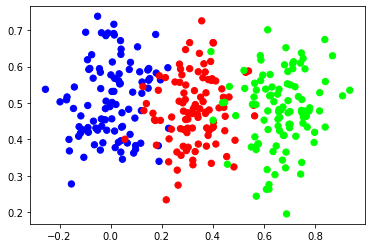

In [2]:
# How can one optimize the weights and biases to reduce loss?

# One option can be randomly changing the weights, checking the loss, and repeating this until lowest loss.
# Below code will describe this approach

import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data

nnfs.init()

X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="brg")
plt.show()


In [13]:
# In the below given approach we try randomly set weights and biases
# and calculate the loss and accuracy.
# If the loss decreases if simply set the new weights as the current weights.

X, y = vertical_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

loss_function = Loss_Categorical_Cross_Entropy()

lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(1000):

    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    if(loss < lowest_loss):

        print("Iteration: ", iteration)
        print("Loss: ", loss)
        print("Accuracy: ", accuracy)

        loss = lowest_loss
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()

# The output of the above code is not desirable, 
# we can see that the accuracy is barely increase and the loss is also slightly decreased.
# We will try another approach below

Iteration:  0
Loss:  1.1016203
Accuracy:  0.3333333333333333
Iteration:  1
Loss:  1.1002508
Accuracy:  0.3333333333333333
Iteration:  2
Loss:  1.0992025
Accuracy:  0.3333333333333333
Iteration:  3
Loss:  1.0986239
Accuracy:  0.3333333333333333
Iteration:  4
Loss:  1.0989311
Accuracy:  0.3333333333333333
Iteration:  5
Loss:  1.0999966
Accuracy:  0.3333333333333333
Iteration:  6
Loss:  1.0996981
Accuracy:  0.3333333333333333
Iteration:  7
Loss:  1.0990195
Accuracy:  0.3333333333333333
Iteration:  8
Loss:  1.1009971
Accuracy:  0.3333333333333333
Iteration:  9
Loss:  1.0989053
Accuracy:  0.3333333333333333
Iteration:  10
Loss:  1.0984299
Accuracy:  0.3333333333333333
Iteration:  11
Loss:  1.0985516
Accuracy:  0.3333333333333333
Iteration:  12
Loss:  1.0987039
Accuracy:  0.3333333333333333
Iteration:  13
Loss:  1.0988864
Accuracy:  0.3333333333333333
Iteration:  14
Loss:  1.1004544
Accuracy:  0.3333333333333333
Iteration:  15
Loss:  1.098729
Accuracy:  0.3333333333333333
Iteration:  16
Loss

In [6]:

X, y = vertical_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

loss_function = Loss_Categorical_Cross_Entropy()

lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(100000):

    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    if loss < lowest_loss:

        print("Iteration: ", iteration)
        print("Loss: ", loss)
        print("Accuracy: {}\n".format(accuracy))

        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss

    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()


Iteration:  0
Loss:  1.0989758
Accuracy: 0.3333333333333333

Iteration:  3
Loss:  1.098763
Accuracy: 0.3333333333333333

Iteration:  6
Loss:  1.0970205
Accuracy: 0.3333333333333333

Iteration:  9
Loss:  1.0968492
Accuracy: 0.63

Iteration:  10
Loss:  1.09537
Accuracy: 0.3333333333333333

Iteration:  18
Loss:  1.0905586
Accuracy: 0.3933333333333333

Iteration:  21
Loss:  1.0845269
Accuracy: 0.3333333333333333

Iteration:  26
Loss:  1.0814284
Accuracy: 0.3333333333333333

Iteration:  28
Loss:  1.0808738
Accuracy: 0.3333333333333333

Iteration:  40
Loss:  1.080295
Accuracy: 0.3333333333333333

Iteration:  42
Loss:  1.0772412
Accuracy: 0.6666666666666666

Iteration:  62
Loss:  1.0767745
Accuracy: 0.5333333333333333

Iteration:  65
Loss:  1.072059
Accuracy: 0.4666666666666667

Iteration:  66
Loss:  1.0715542
Accuracy: 0.53

Iteration:  67
Loss:  1.0705723
Accuracy: 0.63

Iteration:  69
Loss:  1.0623716
Accuracy: 0.5866666666666667

Iteration:  70
Loss:  1.0597392
Accuracy: 0.666666666666666